In [3]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
from matplotlib import pyplot as plt
from pennylane.operation import Operation, AnyWires
import os
import pandas as pd
from scipy.stats import uniform_direction
import seaborn as sns
from pennylane.math import partial_trace

# Number of qubits
num_qubits = 5

# Initialize the device
dev = qml.device("default.qubit", wires=num_qubits)

dev_test= qml.device("default.qubit",
                     wires = 1)

In [6]:


class fqs_op(qml.operation.Operation):
    num_params = 1
    num_wires = qml.operation.AnyWires
    par_domain = "R"

    @staticmethod
    def compute_matrix(axis):  # theta is the rotation angle
        """Custom operation for free-axis rotation"""
        q0, q1, q2, q3 = axis
        H = qml.sum(q0 * qml.Identity(AnyWires),  - 1j * q1 * qml.X(AnyWires), -1j * q2 * qml.Y(AnyWires), -1j * q3 * qml.Z(AnyWires))
        
        return H.matrix()

In [ ]:
def entangling_layer_ladderZ(num_qubits):
    m = 0
    n = 1
    while m+1 < num_qubits:
        qml.CZ(wires=[m,m+1])
        m+=2
    
    while n+1 < num_qubits:
        qml.CZ(wires=[n,n+1])
        n+=2

def entangling_layer_Ansatz_B(num_qubits):
    
    for i in range(num_qubits - 1):
        qml.CZ(wires=[i, i+1])

def entangling_layer_Ansatz_C(num_qubits):
    
    for i in range(num_qubits):
        qml.CZ(wires=[i, (i+1)%num_qubits])

def entangling_layer_Ansatz_D(num_qubits):
    
    for i in range(num_qubits - 1):
        qml.CZ(wires=[0, i+1])




@qml.qnode(dev)
def circuit_vector(n_vectors, num_layers, ansatz):
    """Parameterized quantum circuit with free-axis rotations"""

    for j in range(num_layers):
        for k in range(num_qubits):
            fqs_op(n_vectors[k + num_qubits * j], wires = k)
        

        if ansatz == "A":
            entangling_layer_ladderZ(num_qubits)
        elif ansatz == "B":
            entangling_layer_Ansatz_B(num_qubits)
        elif ansatz == "C":
            entangling_layer_Ansatz_C(num_qubits)
        elif ansatz == "D":
            entangling_layer_Ansatz_D(num_qubits)

    return qml.state()

In [10]:
# Von Neumann entropy function
def von_neumann_entropy(rho):
    eigvals = np.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]
    return -np.sum(eigvals * np.log2(eigvals))


def reduced_dm(wires_to_keep, density_matrix):
    traced_out = [i for i in range(num_qubits) if i not in wires_to_keep]
    return partial_trace(density_matrix, traced_out)


def process_sample(num_layers, n_vectors, ansatz):
    
    state_vec = circuit_vector(num_layers=num_layers, n_vectors=n_vectors, ansatz=ansatz)
    density_matrix = np.outer(state_vec, state_vec.conj())
    mutual_info_matrix = np.zeros((num_qubits, num_qubits))

    for i in range(num_qubits):
        rho_i = reduced_dm(wires_to_keep=[i], density_matrix=density_matrix)
        S_i = von_neumann_entropy(rho_i)
        for j in range(num_qubits):
            if i == j:
                continue
            rho_j = reduced_dm(wires_to_keep=[j], density_matrix=density_matrix)
            rho_ij = reduced_dm(wires_to_keep=[i, j], density_matrix=density_matrix)
            S_j = von_neumann_entropy(rho_j)
            S_ij = von_neumann_entropy(rho_ij)
            mutual_info_matrix[i, j] = S_i + S_j - S_ij

    return mutual_info_matrix

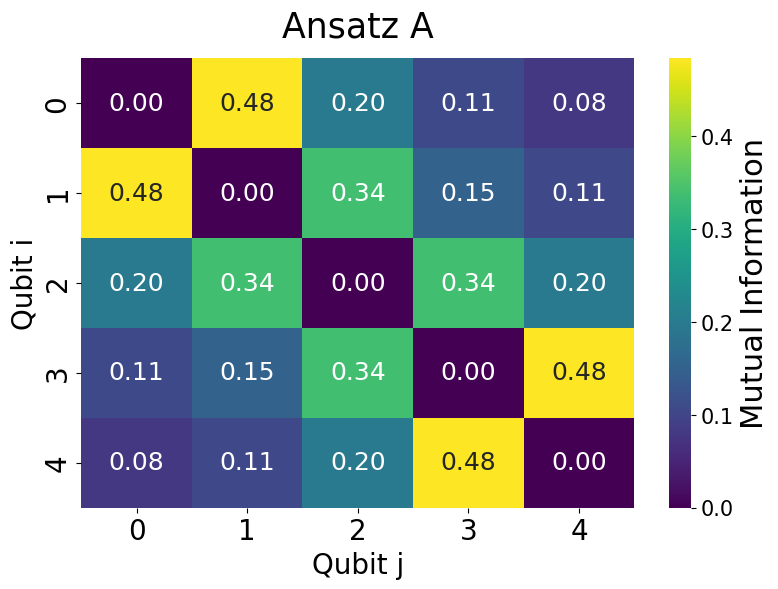

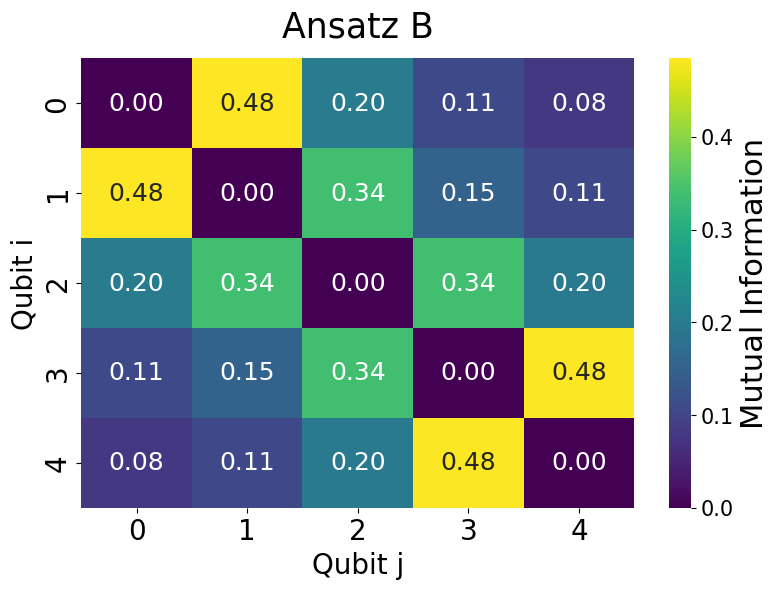

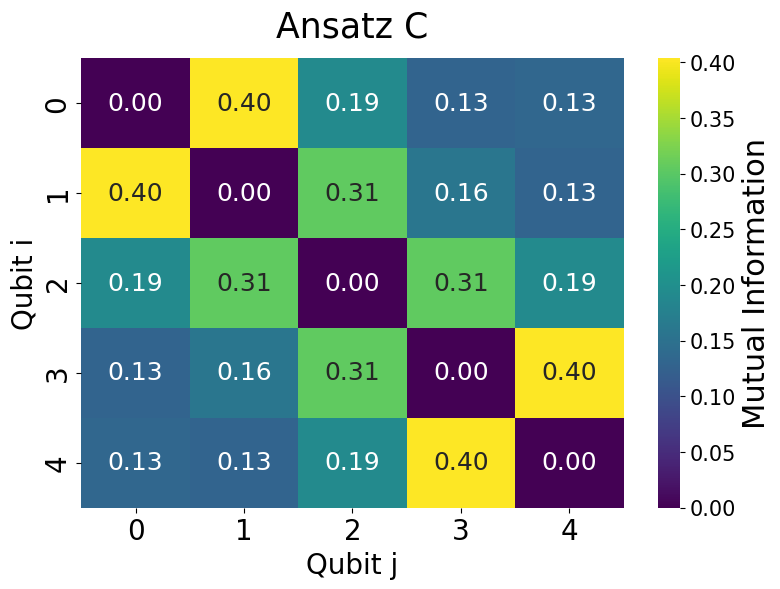

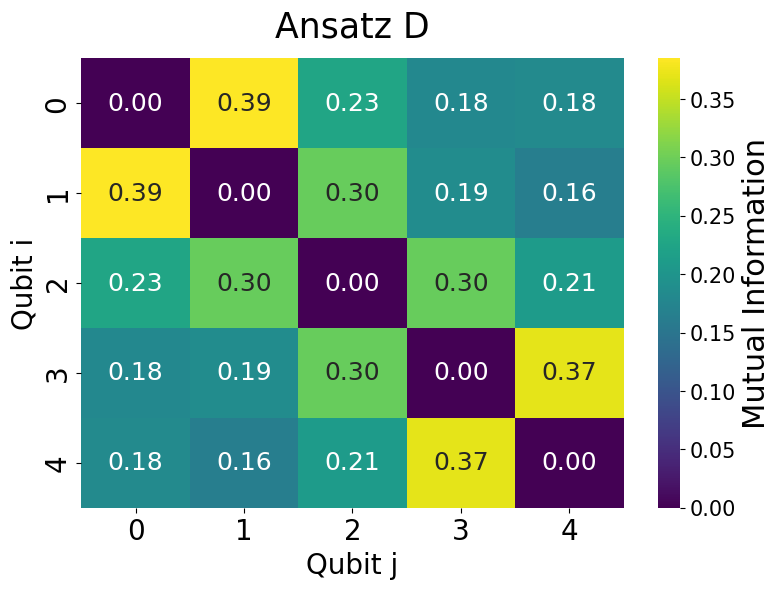

In [ ]:
num_layers = 3
num_samples = 10000

all_matrices = []

ansatze = ["A", "B", "C", "D"]

for ansatz in ansatze:
    for j in range(num_samples):
        num_gates = num_qubits * num_layers
        uniform_sphere_dist = uniform_direction(4)
        n_vectors = uniform_sphere_dist.rvs(num_gates)

        mutual_info_matrix = process_sample(num_layers, n_vectors, ansatz)
        all_matrices.append(mutual_info_matrix)


    avg_mutual_info = np.mean(all_matrices, axis=0)

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(avg_mutual_info, 
                annot=True, 
                fmt=".2f", 
                cmap="viridis", 
                xticklabels=range(num_qubits), 
                yticklabels=range(num_qubits),
                annot_kws={"size": 18})
    plt.title(f"Ansatz {ansatz}", fontsize = 25, y = 1.03)
    plt.xlabel("Qubit j",  fontsize = 20)
    plt.ylabel("Qubit i",  fontsize = 20)
    plt.tick_params(axis="both", labelsize = 20)

    colorbar = ax.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=15)
    colorbar.set_label("Mutual Information")
    ax.figure.axes[-1].yaxis.label.set_size(22)

    plt.tight_layout()
    plt.savefig(f"Mutual_info_FQS_{num_qubits}Q_heatmap_average_{num_samples}_{num_layers}layers_ansatz_{ansatz}.pdf",  bbox_inches='tight')